<a href="https://colab.research.google.com/github/veryHapppy/study_ai/blob/main/Kaggle/predicting_student_test_scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import RidgeCV

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
import joblib

Mounted at /content/drive


In [ ]:
'''
id -> index
gender -> one-hot
course -> one-hot

study_hours
2이하 점수 90이상은 제거
6이상 점수 30이하 제거
나머지 Q1, Q3 상한선으로 변경

internet_access는 단독 사용X 다른 변수랑 엮기?

''' ''''''

'\nid -> index\ngender -> one-hot\ncourse -> one-hot\n\nstudy_hours\n2이하 점수 90이상은 제거\n6이상 점수 30이하 제거\n나머지 Q1, Q3 상한선으로 변경\n\ninternet_access는 단독 사용X 다른 변수랑 엮기?\n\n'

In [ ]:
def feature_engineering(data) :
  data = data.set_index(data['id']).drop('id', axis=1)
  data = pd.get_dummies(data, columns=['study_method', 'facility_rating'])
  #data['course_level'] = data['course'].map(COURSE_MAP).fillna(GLOBAL_MEAN)

  difficulty_map = {'Easy': 1, 'Medium': 2, 'Hard': 3}
  quality_map = {'Poor': 1, 'Average': 2, 'Good': 3}
  data['exam_difficulty_num'] = data['exam_difficulty'].map(difficulty_map)
  data['sleep_quality_num'] = data['sleep_quality'].map(quality_map)

  data['coaching_efficiency'] = data['study_hours'] * data['study_method_coaching']

  if 'exam_score' in data.columns :
    data = data.drop(data[(data['study_hours']<2) & (data['exam_score']>90)].index)
    data = data.drop(data[(data['study_hours']>6) & (data['exam_score']<30)].index)
  else :
    pass


  data = data.drop(['course', 'gender', 'internet_access', 'exam_difficulty', 'sleep_quality'], axis=1)

  return data

In [ ]:
data_set = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/[Kaggle 6-1] Predicting Student Test Scores/train.csv')

COURSE_MAP = data_set.groupby('course')['exam_score'].mean().to_dict()
GLOBAL_MEAN = data_set['exam_score'].mean()

train_data = feature_engineering(data_set)
X = train_data.drop('exam_score', axis=1)
y = train_data['exam_score']

In [ ]:
model = XGBRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train,y_train)
pred = model.predict(X_test)
print(root_mean_squared_error(y_test, pred))


9.501694883636237


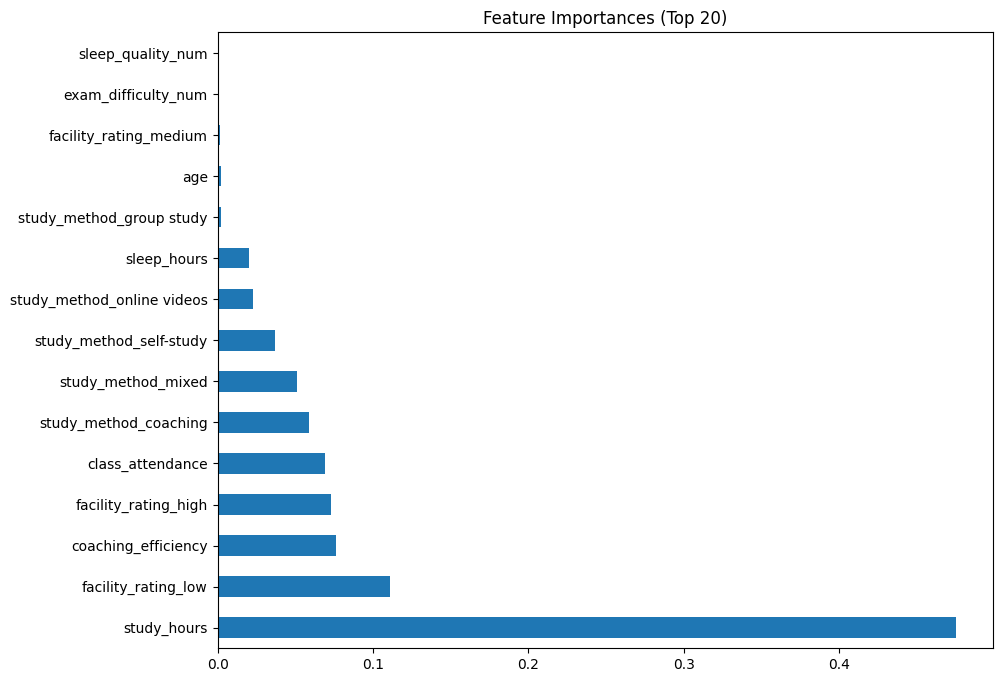

In [ ]:
ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

# 상위 20개 출력
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(10, 8))
plt.title('Feature Importances (Top 20)')
ftr_top20.plot(kind='barh')
plt.show()

In [ ]:
def objective(trial) :
  xgb_params = {
    'n_estimators': trial.suggest_int('xgb_n', 500, 2000),
    'max_depth': trial.suggest_int('xgb_depth', 3, 7),
    'colsample_bytree': trial.suggest_float('xgb_colsample', 0.6, 0.8),
    'reg_alpha': trial.suggest_float('xgb_alpha', 1e-3, 10.0, log=True),
    'reg_lambda': trial.suggest_float('xgb_lambda', 1e-3, 10.0, log=True),
    'learning_rate': trial.suggest_float('xgb_lr', 0.005, 0.1),
  }
  lgbm_params = {
    'n_estimators': trial.suggest_int('lgbm_n', 500, 2000),
    'num_leaves': trial.suggest_int('lgbm_leaves', 15, 50),
    'learning_rate': trial.suggest_float('lgbm_lr', 0.005, 0.1),
    'verbose': -1
  }
  cat_params = {
    'iterations': trial.suggest_int('cat_iter', 500, 2000),
    'depth': trial.suggest_int('cat_depth', 3, 7),
    'learning_rate': trial.suggest_float('cat_lr', 0.005, 0.1),
    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
    'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
    'logging_level': 'Silent' # CatBoost 조용히 시키기
  }
  w_xgb = trial.suggest_float('w_xgb', 0.5, 2.0)
  w_lgbm = trial.suggest_float('w_lgbm', 0.5, 2.0)
  w_cat = trial.suggest_float('w_cat', 0.5, 2.0)

  xgb = XGBRegressor(**xgb_params, tree_method='hist', device='cuda', n_jobs=-1, random_state=42)
  lgbm = LGBMRegressor(**lgbm_params, device='gpu', n_jobs=-1, random_state=42)
  cat = CatBoostRegressor(**cat_params, task_type='GPU', bootstrap_type='Poisson', random_state=42)

  voting_model = VotingRegressor(
    estimators=[('xgb', xgb), ('lgbm', lgbm), ('cat', cat)],
    weights=[w_xgb, w_lgbm, w_cat],
  )

  score = cross_val_score(voting_model, X, y, cv=5, scoring='neg_root_mean_squared_error')

  return -score.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=80)
print(study.best_value)

[I 2026-01-28 06:25:15,962] A new study created in memory with name: no-name-8375213f-e50c-4a23-b8b6-67b639a4ec0b
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [06:25:48] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2026-01-28 06:28:04,699] Trial 0 finished with value: 9.45029460954038 and parameters: {'xgb_n': 1359, 'xgb_depth': 6, 'xgb_colsample': 0.622894018081431, 'xgb_alpha': 0.6930840651811242, 'xgb_lambda': 3.5304173213120555, 'xgb_lr': 0.05864869152103506, 'lgbm_n': 793, 'lgbm_leaves': 46, 'lgbm_lr': 0.04074369420059396, 'cat_iter': 548, 'c

9.437648228659242


In [ ]:

best = study.best_params

xgb_final = XGBRegressor(
    n_estimators=best['xgb_n'],
    max_depth=best['xgb_depth'],
    learning_rate=best['xgb_lr'],
    colsample_bytree=best['xgb_colsample'],
    reg_alpha=best['xgb_alpha'],
    reg_lambda=best['xgb_lambda'],
    random_state=42,
    tree_method='hist',
    device='cuda',
)

lgbm_final = LGBMRegressor(
    n_estimators=best['lgbm_n'],
    num_leaves=best['lgbm_leaves'],
    learning_rate=best['lgbm_lr'],
    random_state=42,
    verbose=-1,
    device='gpu',
)

cat_final = CatBoostRegressor(
    iterations=best['cat_iter'],
    depth=best['cat_depth'],
    learning_rate=best['cat_lr'],
    l2_leaf_reg=best['l2_leaf_reg'],
    random_strength=best['random_strength'],
    task_type='GPU', # GPU 사용
    devices='0',
    random_state=42,
    logging_level='Silent'
)

voting_model = VotingRegressor(
    estimators=[('xgb', xgb_final), ('lgbm', lgbm_final), ('cat', cat_final)],
    weights=[best['w_xgb'], best['w_lgbm'], best['w_cat']]
)

stacking_model = StackingRegressor(
    estimators=[('xgb', xgb_final), ('lgbm', lgbm_final), ('cat', cat_final)],
    final_estimator=RidgeCV(),
    cv=5
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

voting_model.fit(X_train, y_train)
stacking_model.fit(X_train, y_train)

voting_pred = voting_model.predict(X_test)
stacking_pred = stacking_model.predict(X_test)

print(f'voting 오차 : {root_mean_squared_error(y_test, voting_pred)}')
print(f'stacking 오차 : {root_mean_squared_error(y_test, stacking_pred)}')

joblib.dump(voting_model, 'voting_best.pkl')
joblib.dump(stacking_model, 'stacking_best.pkl')

if root_mean_squared_error(y_test, voting_pred) < root_mean_squared_error(y_test, stacking_pred) :
  best_model = voting_model
else :
  best_model = stacking_model

best_model.fit(X, y)
joblib.dump(best_model, 'best_model.pkl')

voting 오차 : 9.44919856633574
stacking 오차 : 9.44740720832809


['best_model.pkl']

In [ ]:

test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/[Kaggle 6-1] Predicting Student Test Scores/test.csv')
X = feature_engineering(test_data)

model = joblib.load('best_model.pkl')
pred = model.predict(X)
pred = np.clip(pred, 0, 100)

submission = pd.DataFrame({
    'id': X.index,
    'exam_score': pred
})

submission.to_csv('submission.csv', index=False)
print("파일 생성 완료")

파일 생성 완료


In [ ]:
import os
save_path = '/content/drive/MyDrive/Colab Notebooks/[Kaggle 6-1] Predicting Student Test Scores/'
submission.to_csv(save_path + 'submission.csv', index=False)